In [1]:

import scipy.io     # used to load .mat data
from scipy.io import savemat

import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import tqdm
import seaborn as sns

from models import MLP, TandemNet, cVAE, cGAN, INN, cVAE_new, cVAE_GSNN, cVAE_Full, cVAE_hybrid
from utils import evaluate_simple_inverse, evaluate_tandem_accuracy, evaluate_vae_inverse, evaluate_vae_minmax_inverse,evaluate_vae_minmax_GSNN_inverse, evaluate_gan_inverse, evaluate_inn_inverse
from utils import evaluate_vae_hybrid_minmax_inverse
from configs import get_configs
from plotting_utils import compare_cie_dist, compare_param_dist, plot_cie, plot_cie_raw_pred
from datasets import get_dataloaders, SiliconColor

from sklearn.metrics import r2_score

#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'
train_loader, val_loader, test_loader = get_dataloaders('tandem_net')

forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained.pth')['model_state_dict'])


<All keys matched successfully>

## Influence of dimension of latent variables

Simple net Design RMSE loss 0.384
Simple net RMSE loss 89.781
Reconstruct RMSE loss 0.157
Reconstruct RMSE loss raw 0.085


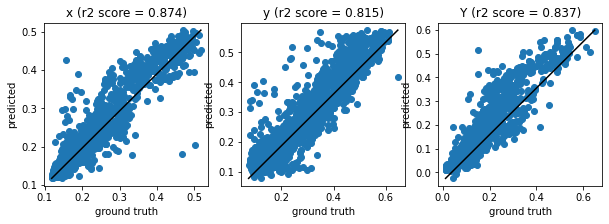

Simple net Design RMSE loss 0.387
Simple net RMSE loss 90.301
Reconstruct RMSE loss 0.149
Reconstruct RMSE loss raw 0.082


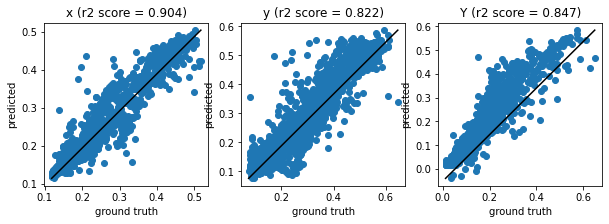

Simple net Design RMSE loss 0.386
Simple net RMSE loss 90.273
Reconstruct RMSE loss 0.161
Reconstruct RMSE loss raw 0.088


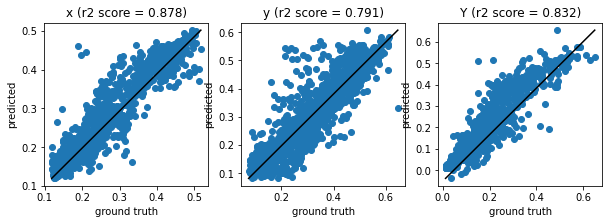

Simple net Design RMSE loss 0.398
Simple net RMSE loss 93.463
Reconstruct RMSE loss 0.156
Reconstruct RMSE loss raw 0.086


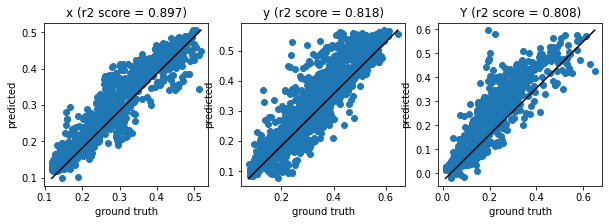

In [105]:
# min-max pure laten dimension 1
configs = get_configs('vae')
configs['latent_dim'] = 1
vae_model = cVAE(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_trained_minmax_1.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

# min-max pure laten dimension 2
configs = get_configs('vae')
configs['latent_dim'] = 2
vae_model = cVAE(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_trained_minmax_2.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

# min-max pure laten dimension 3
configs = get_configs('vae')
configs['latent_dim'] = 3
vae_model = cVAE(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_trained_minmax_3.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

# min-max pure laten dimension 5
configs = get_configs('vae')
configs['latent_dim'] = 5
vae_model = cVAE(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_trained_minmax_5.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)


## Redesign the Model: GSNN

Simple net Design RMSE loss 0.352
Simple net RMSE loss 81.419
Reconstruct RMSE loss 0.125
Reconstruct RMSE loss raw 0.068


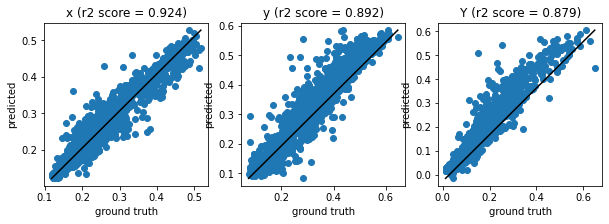

In [106]:
# GSNN no loss on predicted x 
configs = get_configs('vae_GSNN')
configs['latent_dim'] = 5
vae_model = cVAE_GSNN(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_GSNN_trained_no_loss_on_x.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)


Simple net Design RMSE loss 0.355
Simple net RMSE loss 80.992
Reconstruct RMSE loss 0.116
Reconstruct RMSE loss raw 0.064


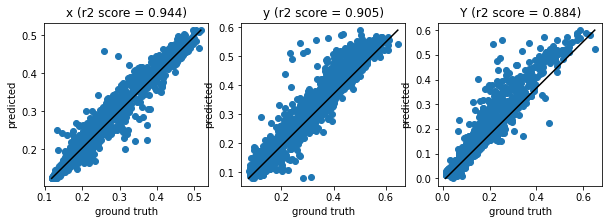

Simple net Design RMSE loss 0.357
Simple net RMSE loss 81.778
Reconstruct RMSE loss 0.115
Reconstruct RMSE loss raw 0.064


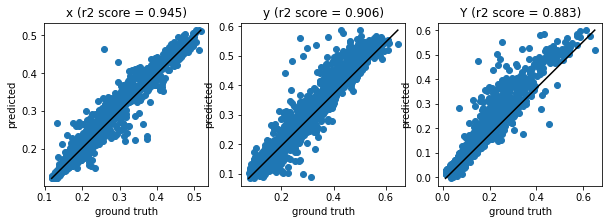

In [107]:
# GSNN add loss on predicted x
# 
configs = get_configs('vae_GSNN')
configs['latent_dim'] = 5
vae_model = cVAE_GSNN(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_GSNN_trained_5.pth')['model_state_dict'])

# Use letent variable to predict
cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

# Use (y->x,y)->z to generate latent variables
cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_GSNN_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

# Save GSNN model predicted data(don't run this!)

In [3]:
# Save loaded data. Don't run this!!!

def struc_check(structure):
    if np.sum(abs(structure)-structure)>0:  # if get negative parameters, then wrong structure
        return 0
    else:
        struc = np.reshape(structure, (-1, 4));
        N = np.shape(struc)[0]
        #print(struc)
        for i in range(N):
            if (struc[i,1]+struc[i,3]>=struc[i,2]):  # if gap+diameter >= period, then wrong structure
                return 0;
            
        return 1;
    
def struc_remove(cie_raw, param_raw, param_pred):
    # remove all structures predicted that is not satisfied by struc_check
    M = np.shape(cie_raw)[0]
    j = 0
    B = []
    for i in range(M-1):
        if struc_check(param_pred[i,:])==0:
            param_pred[j,:] = param_pred[i+1,:]
            param_raw[j,:] = param_raw[i+1,:]
            cie_raw[j,:] = cie_raw[i+1,:]
            B.append(i)
            print(i,j)
        else:
            param_pred[j,:] = param_pred[i,:]
            param_raw[j,:] = param_raw[i,:]
            cie_raw[j,:] = cie_raw[i,:]
            j = j+1
    i = i+1
    
    if struc_check(param_pred[i,:])==0:
        param_pred = param_pred[0:j,:]
        param_raw = param_raw[0:j,:]
        cie_raw = cie_raw[0:j,:]
    else:
        param_pred[j,:] = param_pred[i,:]
        param_raw[j,:] = param_raw[i,:]
        cie_raw[j,:] = cie_raw[i,:]
        param_pred = param_pred[0:(j+1),:]
        param_raw = param_raw[0:(j+1),:]
        cie_raw = cie_raw[0:(j+1),:]

    return B, cie_raw, param_raw, param_pred
print('Okay')

Okay


In [9]:
# do not run this!!!!

M = 1411

total = 10
param_pred_all = np.zeros([M, 4*total])
cie_pred_all = np.zeros([M, 3*total])

configs = get_configs('vae_GSNN')
vae_model = cVAE_GSNN(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_GSNN_trained_4.pth')['model_state_dict'])

for i in range(total):
    cie_raw, param_raw, cie_pred, param_pred =  evaluate_vae_minmax_GSNN_inverse(forward_model, vae_model, configs, test_loader.dataset)
    cie_pred_all[:,(3*i):(3*i+3)], param_pred_all[:,(4*i):(4*i+4)]= cie_pred, param_pred
    
mdic = {"param_pred_all": param_pred_all,"cie_pre_all":cie_pred_all,"param_test_all": param_raw,"CIE_x_all": cie_raw}
savemat("data_predicted\param_vae_GSNN_pred_all.mat",mdic)


B, temp_1, temp_2, temp_3= struc_remove(cie_raw, param_raw, param_pred_all)
cie_pred_all = np.delete(cie_pred_all, B, 0)
cie_raw = np.delete(cie_raw, B, 0)
param_pred_all = np.delete(param_pred_all, B, 0)
param_raw = np.delete(param_raw, B, 0)

# Saving the predicted data
mdic = {"param_pred": param_pred_all,"param_test": param_raw,"cie_pred": cie_pred_all, "CIE_x": cie_raw, "deleted_row":B}
savemat("data_predicted\param_vae_GSNN_pred.mat",mdic)

print(param_pred[1,:])

np.shape(param_pred)

Simple net Design RMSE loss 0.353
Simple net RMSE loss 81.111
Reconstruct RMSE loss 0.117
Reconstruct RMSE loss raw 0.063
Simple net Design RMSE loss 0.353
Simple net RMSE loss 81.076
Reconstruct RMSE loss 0.116
Reconstruct RMSE loss raw 0.063
Simple net Design RMSE loss 0.353
Simple net RMSE loss 81.002
Reconstruct RMSE loss 0.117
Reconstruct RMSE loss raw 0.063
Simple net Design RMSE loss 0.354
Simple net RMSE loss 81.173
Reconstruct RMSE loss 0.118
Reconstruct RMSE loss raw 0.064
Simple net Design RMSE loss 0.353
Simple net RMSE loss 81.090
Reconstruct RMSE loss 0.117
Reconstruct RMSE loss raw 0.064
Simple net Design RMSE loss 0.353
Simple net RMSE loss 81.143
Reconstruct RMSE loss 0.118
Reconstruct RMSE loss raw 0.064
Simple net Design RMSE loss 0.352
Simple net RMSE loss 80.875
Reconstruct RMSE loss 0.118
Reconstruct RMSE loss raw 0.064
Simple net Design RMSE loss 0.353
Simple net RMSE loss 80.943
Reconstruct RMSE loss 0.117
Reconstruct RMSE loss raw 0.063
Simple net Design RMSE l

(1411, 4)

## Evaluate the GSNN model using RCWA:

In [2]:
def best_xyY(xyY_test, xyY_ideal):
    # find the best performance of xyY
    M = np.shape(xyY_test)[0]
    xyY_ideal = np.tile(xyY_ideal, (M,1))
    
    # use square root to measure the distance
    distance = np.sum(np.square(xyY_test -xyY_ideal),1)
    # use absolute value to measure the distance 
    #distance = np.sum(np.abs(xyY_test -xyY_ideal),1)
    return np.where(distance ==np.min(distance))

def best_struc(struc_test, struc_ideal):
    # find the best performance of xyY
    M = np.shape(struc_test)[0]
    struc_ideal = np.tile(struc_ideal, (M,1))
    
    # use square root to measure the distance
    distance = np.sum(np.square(struc_test -struc_ideal),1)
    # use absolute value to measure the distance 
    #distance = np.sum(np.abs(xyY_test -xyY_ideal),1)
    return np.where(distance ==np.min(distance))



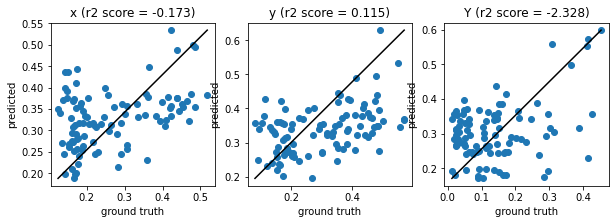

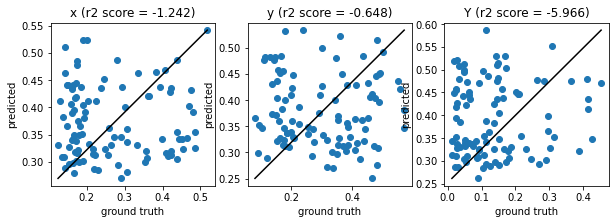

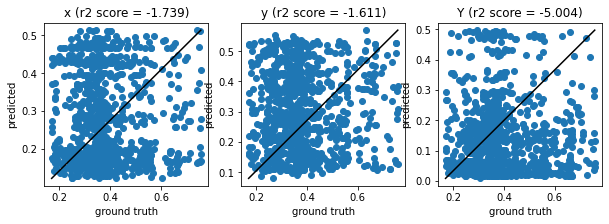

In [98]:
filepath ="data_predicted/xyY/xyY_param_vae_GSNN_pred.mat"
filepath2 = "data_predicted\param_vae_GSNN_pred.mat"

temp = scipy.io.loadmat(filepath)
CIE_x = np.array(list(temp.items())[3][1]) # original one
param_pred = np.array(list(temp.items())[5][1])
param_pred_vae = np.reshape(param_pred, (-1, 4))
param_test = np.array(list(temp.items())[6][1])
param_test_vae = np.reshape(param_test, (-1, 4))
xyY_pred = np.array(list(temp.items())[7][1])  # predicted by RCWA

cie_pred =  np.array(list(temp.items())[4][1])  # predicted by forward model

xyY_temp = np.reshape(xyY_pred, (-1, 3))
M = np.shape(xyY_pred)[0]
xyY_pred_avg = np.zeros([M, 3])
xyY_pred_best = np.zeros([M, 3])

for i in range(0,M):
    temp = xyY_temp[(5*i):(5*i+5),:]
    temp[np.isnan(temp)] = 0
    xyY_pred_avg[i,:] = np.average(temp, axis=0)
    xyY_pred_best[i,:] = temp[best_xyY(temp, CIE_x[i,:]),:]

CIE_x_all = np.concatenate((CIE_x, CIE_x, CIE_x), axis=1)
CIE_x_all = np.concatenate((CIE_x_all, CIE_x_all, CIE_x_all, CIE_x_all), axis=1)
CIE_x_all = np.reshape(CIE_x_all,(-1,3))

# Evaluation 1: comparing the CIE target against the actual best CIE using RCWA 
plot_cie_raw_pred(CIE_x, xyY_pred_best)

# Evaluation 2：comparing the CIE target against the actual average CIE using RCWA 
plot_cie_raw_pred(CIE_x, xyY_pred_avg)

# Evaluation 3: comparing the estimated CIE using the forward model against the actual CIE using RCWA
plot_cie_raw_pred(np.reshape(xyY_pred,(-1,3)), np.reshape(cie_pred,(-1,3)))

In [99]:
xyY_pred

array([[0.30952269, 0.25697849, 0.35709639, ..., 0.40832263, 0.54697141,
        0.46904537],
       [0.34257712, 0.35311124, 0.36169984, ..., 0.40853634, 0.5597684 ,
        0.5597302 ],
       [0.35554593, 0.26299694, 0.29222416, ..., 0.53879751, 0.55962699,
        0.4427318 ],
       ...,
       [0.25489017, 0.29125487, 0.36374761, ..., 0.67001599, 0.30194423,
        0.42065993],
       [0.38711206, 0.23425   , 0.35741946, ..., 0.4830288 , 0.27518531,
        0.70360223],
       [0.31752837, 0.19373142, 0.33505973, ..., 0.3884752 , 0.66880365,
        0.54268581]])

# Redesign the Model: Full model

Simple net Design RMSE loss 0.357
Simple net RMSE loss 82.252
Reconstruct RMSE loss 0.119
Reconstruct RMSE loss raw 0.065


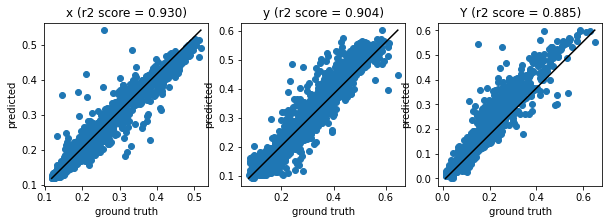

In [3]:
# GSNN add loss on predicted x
# 
configs = get_configs('vae_Full')
vae_model = cVAE_Full(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_Full_trained_5.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)


In [10]:
# do not run this!!!!

M = 1411

total = 10
param_pred_all = np.zeros([M, 4*total])
cie_pred_all = np.zeros([M, 3*total])

configs = get_configs('vae_Full')
vae_model = cVAE_Full(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_Full_trained_5.pth')['model_state_dict'])

for i in range(total):
    cie_raw, param_raw, cie_pred, param_pred =  evaluate_vae_minmax_GSNN_inverse(forward_model, vae_model, configs, test_loader.dataset)
    cie_pred_all[:,(3*i):(3*i+3)], param_pred_all[:,(4*i):(4*i+4)]= cie_pred, param_pred
    
mdic = {"param_pred_all": param_pred_all,"cie_pre_all":cie_pred_all,"param_test_all": param_raw,"CIE_x_all": cie_raw}
savemat("data_predicted\param_vae_Full_pred_all.mat",mdic)


B, temp_1, temp_2, temp_3= struc_remove(cie_raw, param_raw, param_pred_all)
cie_pred_all = np.delete(cie_pred_all, B, 0)
cie_raw = np.delete(cie_raw, B, 0)
param_pred_all = np.delete(param_pred_all, B, 0)
param_raw = np.delete(param_raw, B, 0)


# Saving the predicted data
mdic = {"param_pred": param_pred_all,"param_test": param_raw,"cie_pred": cie_pred_all, "CIE_x": cie_raw, "deleted_row":B}
savemat("data_predicted\param_vae_Full_pred.mat",mdic)

print(param_pred[1,:])

np.shape(param_pred)

Simple net Design RMSE loss 0.359
Simple net RMSE loss 82.611
Reconstruct RMSE loss 0.121
Reconstruct RMSE loss raw 0.067
Simple net Design RMSE loss 0.360
Simple net RMSE loss 83.233
Reconstruct RMSE loss 0.120
Reconstruct RMSE loss raw 0.066
Simple net Design RMSE loss 0.358
Simple net RMSE loss 82.434
Reconstruct RMSE loss 0.119
Reconstruct RMSE loss raw 0.065
Simple net Design RMSE loss 0.360
Simple net RMSE loss 83.290
Reconstruct RMSE loss 0.119
Reconstruct RMSE loss raw 0.066
Simple net Design RMSE loss 0.360
Simple net RMSE loss 82.877
Reconstruct RMSE loss 0.119
Reconstruct RMSE loss raw 0.065
Simple net Design RMSE loss 0.360
Simple net RMSE loss 83.237
Reconstruct RMSE loss 0.122
Reconstruct RMSE loss raw 0.067
Simple net Design RMSE loss 0.362
Simple net RMSE loss 83.377
Reconstruct RMSE loss 0.121
Reconstruct RMSE loss raw 0.066
Simple net Design RMSE loss 0.358
Simple net RMSE loss 82.528
Reconstruct RMSE loss 0.122
Reconstruct RMSE loss raw 0.067
Simple net Design RMSE l

(1411, 4)

# Redesign the Model: Hybrid model

Simple net Design RMSE loss 0.372
Simple net RMSE loss 86.263
Reconstruct RMSE loss 0.073
Reconstruct RMSE loss raw 0.039


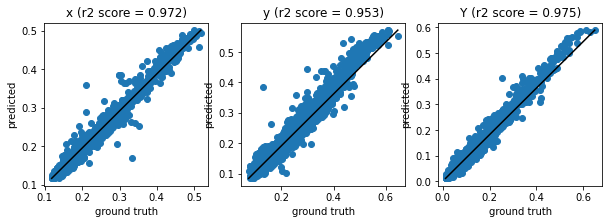

Simple net Design RMSE loss 0.367
Simple net RMSE loss 85.213
Reconstruct RMSE loss 0.065
Reconstruct RMSE loss raw 0.035


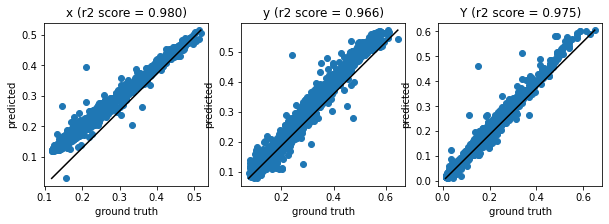

In [87]:
# Train the vae based on forward model
# the vae odeel is pre-loaded from cVAE_full_5 model, and forward model is fixed. 
# This is more stable. 
forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained.pth')['model_state_dict'])
configs = get_configs('vae_hybrid')
vae_model = cVAE_Full(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_Full_trained_5.pth')['model_state_dict'])
model = cVAE_hybrid(forward_model, vae_model)

model.load_state_dict(torch.load('./models/vae_hybrid_trained_5_pretrained_100.pth')['model_state_dict'])
cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_hybrid_minmax_inverse(forward_model, model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

model = cVAE_hybrid(forward_model, vae_model)
model.load_state_dict(torch.load('./models/vae_hybrid_trained_5_pretrained_500.pth')['model_state_dict'])
cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_hybrid_minmax_inverse(forward_model, model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)


Simple net Design RMSE loss 0.378
Simple net RMSE loss 88.501
Reconstruct RMSE loss 0.060
Reconstruct RMSE loss raw 0.032


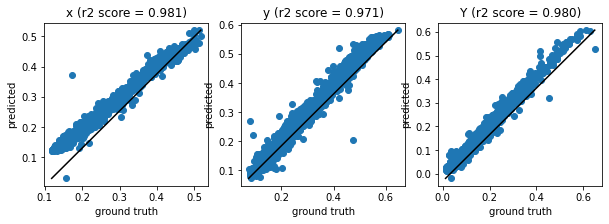

In [92]:
# Train the vae based on forward model
# the vae odeel is not pre-loaded from cVAE_full_5 model, and forward model is fixed. 

forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained.pth')['model_state_dict'])
configs = get_configs('vae_hybrid')
vae_model = cVAE_Full(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_Full_trained_5.pth')['model_state_dict'])
model = cVAE_hybrid(forward_model, vae_model)

model.load_state_dict(torch.load('./models/vae_hybrid_trained_5_no_pretrained.pth')['model_state_dict'])
cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_hybrid_minmax_inverse(forward_model, model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)


# Save predicted data for cVAE hydrid

In [5]:
# do not run this!!!!

M =1411

total = 10
param_pred_all = np.zeros([M, 4*total])
cie_pred_all = np.zeros([M, 3*total])

forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained.pth')['model_state_dict'])
configs = get_configs('vae_hybrid')
vae_model = cVAE_Full(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_Full_trained_5.pth')['model_state_dict'])

vae_model = cVAE_hybrid(forward_model, vae_model)

vae_model.load_state_dict(torch.load('./models/vae_hybrid_trained_5_no_pretrained.pth')['model_state_dict'])

for i in range(total):
    cie_raw, param_raw, cie_pred, param_pred =  evaluate_vae_hybrid_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset)
    cie_pred_all[:,(3*i):(3*i+3)], param_pred_all[:,(4*i):(4*i+4)]= cie_pred, param_pred
    
mdic = {"param_pred_all": param_pred_all,"cie_pre_all":cie_pred_all,"param_test_all": param_raw,"CIE_x_all": cie_raw}
savemat("data_predicted\param_vae_hybrid_pred_all.mat",mdic)


B, cie_raw, param_raw, param_pred= struc_remove(cie_raw, param_raw, param_pred_all)
cie_pred_all = np.delete(cie_pred_all, B, 0)
param_pred_all = np.delete(param_pred_all, B, 0)

# Saving the predicted data
mdic = {"param_pred": param_pred_all,"param_test": param_raw,"cie_pred": cie_pred_all, "CIE_x": cie_raw, "deleted_row":B}
savemat("data_predicted\param_vae_hybrid_pred.mat",mdic)


Simple net Design RMSE loss 0.378
Simple net RMSE loss 88.336
Reconstruct RMSE loss 0.059
Reconstruct RMSE loss raw 0.032
Simple net Design RMSE loss 0.377
Simple net RMSE loss 88.303
Reconstruct RMSE loss 0.059
Reconstruct RMSE loss raw 0.032
Simple net Design RMSE loss 0.380
Simple net RMSE loss 88.749
Reconstruct RMSE loss 0.064
Reconstruct RMSE loss raw 0.034
Simple net Design RMSE loss 0.380
Simple net RMSE loss 88.458
Reconstruct RMSE loss 0.060
Reconstruct RMSE loss raw 0.033
Simple net Design RMSE loss 0.379
Simple net RMSE loss 88.384
Reconstruct RMSE loss 0.059
Reconstruct RMSE loss raw 0.032
Simple net Design RMSE loss 0.377
Simple net RMSE loss 88.097
Reconstruct RMSE loss 0.058
Reconstruct RMSE loss raw 0.032
Simple net Design RMSE loss 0.381
Simple net RMSE loss 89.506
Reconstruct RMSE loss 0.059
Reconstruct RMSE loss raw 0.032
Simple net Design RMSE loss 0.378
Simple net RMSE loss 88.461
Reconstruct RMSE loss 0.060
Reconstruct RMSE loss raw 0.032
Simple net Design RMSE l

# Evaluate the hybrid model using RCWA:

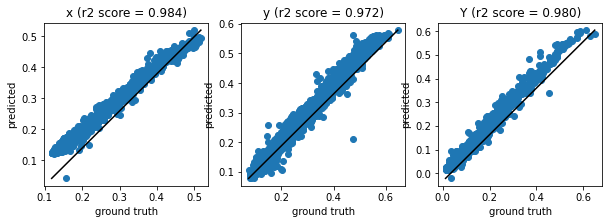

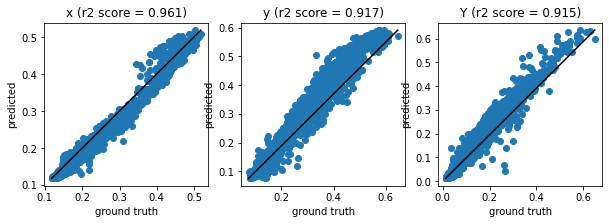

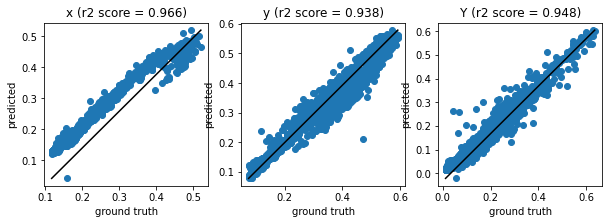

In [12]:
filepath ="data_predicted/xyY/xyY_param_vae_hybrid_pred.mat"
filepath2 = "data_predicted/param_vae_hybrid_pred_all.mat"
filepath3 = "data_predicted/param_vae_hybrid_pred.mat"

temp = scipy.io.loadmat(filepath)
xyY_pred = np.array(list(temp.items())[7][1])  # predicted by RCWA
xyY_pred = xyY_pred[0:1388,:]

temp = scipy.io.loadmat(filepath3)
delete_row = np.array(list(temp.items())[7][1])

temp = scipy.io.loadmat(filepath2)
param_pred = np.array(list(temp.items())[3][1])[:, 0:4]
param_pred = np.delete(param_pred, delete_row, 0)
param_pred = np.delete(param_pred, delete_row, 0)

cie_pred = np.array(list(temp.items())[4][1])[:,0:3] # predicted by forward model
cie_pred = np.delete(cie_pred, delete_row, 0)
cie_pred = np.delete(cie_pred, delete_row, 0)

param_test = np.array(list(temp.items())[5][1])
CIE_x = np.array(list(temp.items())[6][1])  # target
CIE_x = np.delete(CIE_x, delete_row, 0)
CIE_x = np.delete(CIE_x, delete_row, 0)

# Evaluation 1: comparing the CIE target VS forward
plot_cie_raw_pred(CIE_x, cie_pred)

# Evaluation 2：comparing the CIE target VS RCWA
plot_cie_raw_pred(CIE_x, xyY_pred)

# Evaluation 3: comparing the CIE forward VS RCWA
plot_cie_raw_pred(xyY_pred, cie_pred)
